In [4]:
import torch
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

In [5]:
#Importing pyspark.sql for loading the parquet files into a spark dataframe
from pyspark.sql import SparkSession

# Creating a spark session
spark = SparkSession.builder \
    .appName("DatasetCreator") \
    .getOrCreate()

# Loading the parquet files from the directory
parquet_files_path = "/kaggle/input/quark-gluon"
df = spark.read.parquet(parquet_files_path)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/16 11:48:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
#Number of rows to select to train and test the model at a time
num_rows = 1500

In [7]:
#Sampling random n rows from the dataset
df = df.sample(withReplacement=False, fraction=num_rows/df.count())

In [8]:
#Converting df into a pandas dataframe
df = df.toPandas()

In [9]:
#Dividing the dataset into train and test set
spark.stop()

### Processing the Data :-
#### 1. Dividing the data into train and test sets
#### 2. Creating a pytorch Dataset and a Dataloader

In [14]:
X = df.drop('y', axis=1)
y = df['y']

# Splitting the data into train and test sets with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Cropping each of the channel of the image into 9 equal parts and stacking them to create a total
of 30 channels**

In [10]:
import cv2
import numpy as np
def multichanneliser(image):
    # Loading the RGB image
    image = image.reshape((125, 125, 3))

    # Splitting the image into its RGB channels
    b, g, r = cv2.split(image)

    # Determining the dimensions of each part
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3

    # Initializing lists to store the parts of each channel
    b_parts = []
    g_parts = []
    r_parts = []

    # Cropping each channel into 9 equal parts
    for i in range(3):
        for j in range(3):
            # Calculating the cropping boundaries
            y_start = i * part_height
            y_end = (i + 1) * part_height
            x_start = j * part_width
            x_end = (j + 1) * part_width

            # Crop each channel
            b_part = b[y_start:y_end, x_start:x_end]
            g_part = g[y_start:y_end, x_start:x_end]
            r_part = r[y_start:y_end, x_start:x_end]

            # Resize each part to match the dimensions of the original RGB channels
            b_part_resized = cv2.resize(b_part, (width, height))
            g_part_resized = cv2.resize(g_part, (width, height))
            r_part_resized = cv2.resize(r_part, (width, height))

            # Append the resized parts to the respective lists
            b_parts.append(b_part_resized)
            g_parts.append(g_part_resized)
            r_parts.append(r_part_resized)

    # Stacking the parts of each channel together to create 9 channels
    b_stacked = np.stack(b_parts, axis=-1)
    g_stacked = np.stack(g_parts, axis=-1)
    r_stacked = np.stack(r_parts, axis=-1)

    # Combining all channels into a single multi-channel image
    all_channels = np.dstack((b, g, r, b_stacked, g_stacked, r_stacked))
    
    return all_channels

In [11]:
images = torch.stack([torch.tensor(img) for img in df['X_jets']], dim=0)

In [12]:
mean = images.mean(dim=(0, 2, 3))
std = images.std(dim=(0, 2, 3))

In [33]:
#Creating a custom Pytorch Dataset
class QGDataset(Dataset):
    def __init__(self, X, y, transform=False):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        image = torch.tensor(self.X['X_jets'].iloc[idx], dtype=torch.float32)
        image = v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])(image)
            
        image = image.numpy()
            
        image = torch.tensor(multichanneliser(image)).reshape((30, 125, 125))
        image = image.to(torch.float32)
            
        label = self.y.iloc[idx]
            
        return image, label
    
# Train and Test pytorch Datasets

train_dataset = QGDataset(X_train, y_train, True)
test_dataset= QGDataset(X_test, y_test)

#Defining the batch size 
BATCH_SIZE = 32
# Train and test pytorch Dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,  shuffle=False)

### Creating a Resnet Architecture

In [25]:
import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#### Creating the model

In [40]:
model = ResNet(block, [3, 4, 6, 3], 30, 1)

#### Setting the device and transferring the model to it

In [27]:
device = "cuda" if torch.cuda.is_available else 'cpu'

In [41]:
model.to(device)

ResNet(
  (conv1): Conv2d(30, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

#### Defining the loss function and the optimizer

In [42]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

#### Training and Testing the model

In [43]:
# training loop

def train(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    return train_loss / len(train_loader.dataset)

In [44]:
# evaluation loop
def evaluate(model, data_loader, device):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            y_true.extend(targets.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())
    return roc_auc_score(y_true, y_scores)

### Early stopping criteria
##### maxPatience : denotes the maximum patience for monotonic increase in validation loss while the     train loss dicreases.
##### maxTolerance : denotes the maximum patience for increase in validation loss after certain epoch. this increase doesn't have to be strictly monotonic

In [38]:
best_auc = 0.0

In [48]:
epochs = 10
# Setting maximum patience for early stopping
maxPatience = 12
maxTolerance = 12

# Initialize variables for early stopping and plotting
currentPatience = 0
currentTolerance = 0
toleranceValidScore = -1000

# Training loop
for epoch in range(1, epochs + 1):
    print("Epoch {}/{}".format(epoch, epochs))
    train_loss = train(model, criterion, optimizer, train_dataloader, device)
    test_auc = evaluate(model, test_dataloader, device)
    
    print("Train Loss: {:.4f}, Test ROC-AUC: {:.4f}".format(train_loss, test_auc))
    
    # Update patience and tolerance
    if test_auc <= toleranceValidScore:
        currentTolerance += 1
    else:
        currentTolerance = 0
        toleranceValidScore = test_auc
    
    if currentTolerance == maxTolerance:
        print("Early stopping training due to overfitting...")
        break
    
    # Save checkpoint
    if test_auc > best_auc:
        best_auc = test_auc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saving model checkpoint...")
    
    # Update patience for early stopping
    if test_auc <= best_auc:
        currentPatience += 1
    else:
        currentPatience = 0
    
    if currentPatience == maxPatience:
        print("Early stopping training due to overfitting...")
        break

print("Training completed!")

Epoch 1/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0275, Test ROC-AUC: 0.5963
Epoch 2/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0178, Test ROC-AUC: 0.5027
Epoch 3/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0493, Test ROC-AUC: 0.5060
Epoch 4/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0654, Test ROC-AUC: 0.5840
Epoch 5/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0449, Test ROC-AUC: 0.5604
Epoch 6/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0625, Test ROC-AUC: 0.4527
Epoch 7/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0309, Test ROC-AUC: 0.5287
Epoch 8/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0232, Test ROC-AUC: 0.5876
Epoch 9/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0669, Test ROC-AUC: 0.6234
Epoch 10/10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0878, Test ROC-AUC: 0.4469
Training completed!


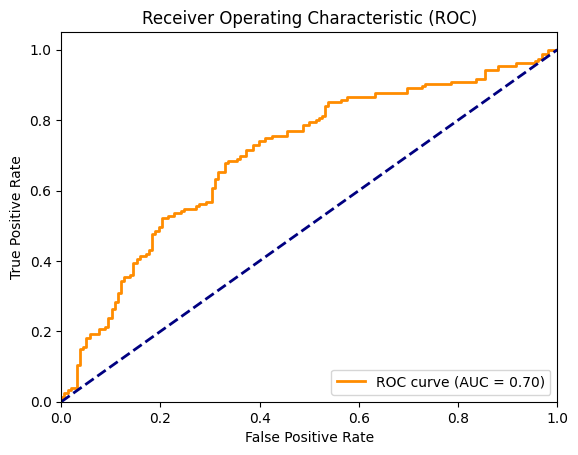

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Evaluating the best model on test data
best_model = ResNet(block, [3, 4, 6, 3], 30, 1).to(device)
best_model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
y_true = []
y_scores = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_model(inputs)
        y_true.extend(targets.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()